> ### EEE4423: Deep Learning Lab

# LAB \#9: Interpretation&Attention: Grad-CAM

<h4><div style="text-align: right"> Due date: 2022.05.06  </div> <br>
<div style="text-align: right"> Please upload your file @ yscec by 9 AM in the form of [ID_Name_Week9.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2017142136] [이관희]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-05-05 04:38:55.938686


## Grad-CAM with pretrained model(AlexNet[2], VGGnet[3])

## Gradient-weighted Class Activation Mapping(Grad-CAM)[1]
>- A techinique for producing 'visual explanations' for decisions from a CNN-based models
>- Higlights the most important (discriminative) image regions related to the specific class
>- Making CNN-based models more transparent
>- Unlike in CAM, any architectural changes or retraining are not needed from any CNN-based networks

<img src="https://docs.google.com/uc?export=view&id=1fIcX1gPOSk1Q6tt4QHUpf0LvQYhb60gE" alt="no_image" style="width: 900px;"/>

### Framework of Grad-CAM
>- A generic version of Class Activation Map(CAM)
>- Using **gradient information** flowing into the last convolutional layer of the CNN to understanding the importance of each neuron for a decision
>- Compute a weighted sum of the feature maps of the last convolutional layer to produce CAM 
>>- Gradient of the score for class c, $y_c$, with respect to feature maps($A^k$) of the last convolutional layer, $\frac{\partial y^c}{\partial A^k}$
>>- These gradients are global-average-pooled to obtain the neuron importance weights ($\alpha_k^c$) : 
$\frac{1}{Z} \sum_{i}\sum_{j} \frac{\partial y^c}{\partial A_ij^k}$ <br>
>>- Grad-CAM mask produced with weighted combination of activation maps, followed by a ReLU: $L_{Grad-CAM}^c = ReLU(\sum_{k} \alpha_k^cA^k)$ 
>
> ++ **We don't use Guided Backpropagation in this part**

<img src="https://docs.google.com/uc?export=view&id=1fPgSB_Bq6PHAnSvtDBI25NYcSMNZmsqO" alt="no_image" style="width: 900px;"/>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import cv2
import io
import requests
import os 
import copy

from PIL import Image
from collections import OrderedDict

%matplotlib inline

In [3]:
# For torchsummary
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install torchsummary
    from torchsummary import summary
    pass

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# hyper-parameters
image_size = 224
num_classes = 1000

### Model (Pre-trained models)

In [6]:
print('STEP 3: CREATE MODEL CLASS (Pre-trained models)')

STEP 3: CREATE MODEL CLASS (Pre-trained models)


#### 1.Write codes for the pretrained model (AlexNet and VGG-16) [2 points]
>- Hint: All learnable parameters' sizes of two models are in the 9th cell below <br>

#### 1.1 AlexNet [1 point]
>- Maxpooling after each convolutional layer
>- Use ReLU as an activation function
>- Dropout before the 1st and 2nd fully-connected layers

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv | 11 | 4 | 2 |
| MaxPool | 3 | 2 | 0 |
| 2nd Conv | 5 | 1 | 2 |
| MaxPool | 3 | 2 | 0 |
| 3rd Conv | 3 | 1 | 1 |
| 4th Conv | 3 | 1 | 1 |
| 5th Conv | 3 | 1 | 1 |
| MaxPool | 3 | 2 | 0 |



In [7]:
# CIVA10 dataset input 이미지의 size는 3,224,224 이다.

# Pre-trained AlexNet from model_zoo
# 질문1 : model_zoo -> Loads the Torch serialized object at the given URL.

pretrained_AlexNet = {'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',}

# 2nd, 3rd, 4th 담당
class AlexNet_Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, maxpool = False):
        super(AlexNet_Block, self).__init__()
        self.conv_repeat = nn.Sequential(
        nn.Conv2d(in_channels=in_ch, out_channels = out_ch, kernel_size=kernel_size,stride=stride, padding=padding),nn.ReLU()
        )
        self.Max_pool=nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.TF=maxpool

    def forward(self, x):
        x= self.conv_repeat(x)
        
        if self.TF :
            x = self.Max_pool(x)
        
        return x
    
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
         # 1st
            nn.Conv2d(in_channels=3, out_channels = 64, kernel_size=11,stride=4, padding=2),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

#         #  2nd 
#         nn.Conv2d(in_channels=64, out_channels = 192, kernel_size=5,stride=1, padding=2),nn.ReLU(),
#         nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            AlexNet_Block(64,192,5,1,2,True),
            
#         # 3rd
#         nn.Conv2d(in_channels=256, out_channels = 384, kernel_size=3, ,stride=1, padding=1),nn.ReLU(),
            AlexNet_Block(192,384,3,1,1,False),

#         # 4th
#         nn.Conv2d(in_channels=384, out_channels = 384, kernel_size=3, ,stride=1, padding=1),nn.ReLU(),
            AlexNet_Block(384,256,3,1,1,False),
          # 5th
            nn.Conv2d(in_channels=256, out_channels = 256, kernel_size=3,stride=1, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),nn.Linear(256*6*6, 4096),nn.ReLU(),
            nn.Dropout(),nn.Linear(4096, 4096),nn.ReLU(),
            nn.Linear(4096,1000)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# model = AlexNet()
# num_total_params = sum(p.numel() for p in model.parameters())
# print("The number of parameters : ", num_total_params)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(model.to(device))
# print(device)

# The number of parameters :  61100840 수 일치

#### 1.2 VGGnet-16 [1 point]
>- No batch normalization and initializtion of weights
>- Model configuration is in the dictionary '*cfg*'
>- Use ReLU as an activation function
>- Dropout before the 2nd and last fully-connected layers

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| Conv | 3 | 1 | 1 |
| MaxPool | 2 | 2 | 0 |



In [8]:
#Pre-trained VGGnet-16 from model_zoo
pretrained_vgg = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
}

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGGnet(nn.Module):
    def __init__(self, features, num_classes=num_classes):
        super(VGGnet, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes) # num_classes=1000
        )
       
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
                
# features 만드는 부분이다.
def make_layers(cfg, batch_norm=False) :
    layers = []
    in_channels=3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = int(v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU()]
            in_channels = v
    return nn.Sequential(*layers)


#### 2.Write codes for the model instantiation(AlexNet and VGG-16) [2 points]

In [9]:
pretrained_AlexNet = {'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',}
pretrained_vgg = {'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',}

print('STEP 4: INSTANTIATE MODEL CLASS')

# AlexNet
def alexnet(model, pretrained=False):
    pretrained_dict = model_zoo.load_url(pretrained_AlexNet['alexnet'])
    pretrained_key = list(pretrained_dict)
    
    new_state_dict = OrderedDict()
    
    model_dict = model.state_dict()
    
    ## 전처리된 parameter을 가져오는 것이다. 순서대로 잘 설계했다면 이름이 달라도 대응되게 업데이트 된다.
    if pretrained:
        for i, (key, value) in enumerate(model_dict.items()):
            new_state_dict[key] = pretrained_dict[pretrained_key[i]]
                
        model.load_state_dict(new_state_dict)
    return model

model_AlexNet = alexnet(AlexNet(), pretrained=True)

# VGG-16, no batch_norm
def vggnet(model, pretrained=False):
    pretrained_dict = model_zoo.load_url(pretrained_vgg['vgg16'])
    pretrained_key = list(pretrained_dict)
    
    new_state_dict = OrderedDict()
    
    model_dict = model.state_dict()

     ## 전처리된 parameter을 가져오는 것이다. 순서대로 잘 설계했다면 이름이 달라도 대응되게 업데이트 된다.
    if pretrained:
        for i, (key, value) in enumerate(model_dict.items()):
            new_state_dict[key] = pretrained_dict[pretrained_key[i]]
                
        # 업데이트 
        model.load_state_dict(new_state_dict)
    return model

model_VGGnet = VGGnet(make_layers(cfg['D'], batch_norm=False))
model_VGGnet = vggnet(model_VGGnet, pretrained=True)

STEP 4: INSTANTIATE MODEL CLASS


여기서 부터는 업데이트가 잘 일어났는지 확인하는 식이다. 

In [10]:
print('model_AlexNet \n{}'.format(model_AlexNet.state_dict().keys()))
print('model_AlexNet_len : {}'.format(len(model_AlexNet.state_dict().keys())))
print('pretrain_AlexNet  \n{}'.format(model_zoo.load_url(pretrained_AlexNet['alexnet']).keys()))
print('pretrain_AlexNet_len : {}'.format(len(model_zoo.load_url(pretrained_AlexNet['alexnet']).keys())))

model_AlexNet 
odict_keys(['features.0.weight', 'features.0.bias', 'features.3.conv_repeat.0.weight', 'features.3.conv_repeat.0.bias', 'features.4.conv_repeat.0.weight', 'features.4.conv_repeat.0.bias', 'features.5.conv_repeat.0.weight', 'features.5.conv_repeat.0.bias', 'features.6.weight', 'features.6.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])
model_AlexNet_len : 16
pretrain_AlexNet  
odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])
pretrain_AlexNet_len : 16


In [11]:
print('model_AlexNet first layer parameter \n{}'.format(model_AlexNet.features[0].weight.flatten()[:5]))
print('pretrain_AlexNet first layer parameter')
print(format(model_zoo.load_url(pretrained_AlexNet['alexnet'])['features.0.weight'].flatten()[:5]))

model_AlexNet first layer parameter 
tensor([0.1186, 0.0941, 0.0954, 0.1052, 0.1029], grad_fn=<SliceBackward>)
pretrain_AlexNet first layer parameter
tensor([0.1186, 0.0941, 0.0954, 0.1052, 0.1029], grad_fn=<SliceBackward>)


In [12]:
print('model_AlexNet first layer parameter \n{}'.format(model_AlexNet.features[3].conv_repeat[0].weight.flatten()[:5]))
print('pretrain_AlexNet first layer parameter')
print(format(model_zoo.load_url(pretrained_AlexNet['alexnet'])['features.3.weight'].flatten()[:5]))

model_AlexNet first layer parameter 
tensor([ 0.0036,  0.0014,  0.0372, -0.0209,  0.0018], grad_fn=<SliceBackward>)
pretrain_AlexNet first layer parameter
tensor([ 0.0036,  0.0014,  0.0372, -0.0209,  0.0018], grad_fn=<SliceBackward>)


In [13]:
print('model_VGG \n{}'.format(model_VGGnet.state_dict().keys()))
print('model_VGG_len : {}'.format(len(model_VGGnet.state_dict().keys())))
print('pretrain_VGG  \n{}'.format(model_zoo.load_url(pretrained_vgg['vgg16']).keys()))
print('pretrain_VGG_len : {}'.format(len(model_zoo.load_url(pretrained_vgg['vgg16']).keys())))

model_VGG 
odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])
model_VGG_len : 32
pretrain_VGG  
odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.wei

In [14]:
print('model_VGG first layer parameter \n{}'.format(model_VGGnet.features[0].weight.flatten()[:5]))
print('pretrain_VGG first layer parameter')
print(format(model_zoo.load_url(pretrained_vgg['vgg16'])['features.0.weight'].flatten()[:5]))

model_VGG first layer parameter 
tensor([-0.5537,  0.1427,  0.5290, -0.5831,  0.3566], grad_fn=<SliceBackward>)
pretrain_VGG first layer parameter
tensor([-0.5537,  0.1427,  0.5290, -0.5831,  0.3566])


In [15]:
print("AlexNet's Summary:")
model_AlexNet.to(device)
summary(model_AlexNet, (3, 224, 224))


print("\nVGGnet's Summary:")
model_VGGnet.to(device)
summary(model_VGGnet, (3, 224, 224))

AlexNet's Summary:


/home/jovyan/.venv/torch1.9.0-py3.8-cuda11.1/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
     AlexNet_Block-7          [-1, 192, 13, 13]               0
            Conv2d-8          [-1, 384, 13, 13]         663,936
              ReLU-9          [-1, 384, 13, 13]               0
    AlexNet_Block-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
    AlexNet_Block-13          [-1, 256, 13, 13]               0
           Conv2d-14          [-1, 256,

### Grad-CAM mask generating and visualizing with given test images

In [22]:
#test images with ImageNet class number
# Colab에서 돌려서 이것만 바꿔주셈
# test_list = (('/content/drive/MyDrive/딥러닝 실험/9주차/kingsnake.jpg', 56),
#              ('/content/drive/MyDrive/딥러닝 실험/9주차/cat_dog.png', 243),
#              ('/content/drive/MyDrive/딥러닝 실험/9주차/cat_dog.png', 282),
#              ('/content/drive/MyDrive/딥러닝 실험/9주차/pizza.jpg', 963))

test_list = (('../dataset/lab09/test_images/kingsnake.jpg', 56),
             ('../dataset/lab09/test_images/cat_dog.png', 243),
             ('../dataset/lab09/test_images/cat_dog.png', 282),
             ('../dataset/lab09/test_images/pizza.jpg', 963))

#imagenet class
imagenet_class = {56: 'king snake', 243: 'bull mastiff', 282: 'tiger cat', 963: 'pizza'}

#### Grad-CAM generator class 
#### 3.Write codes for the Grad-CAM generator class [6 points]
>- Use pre-trained models
>- Similar to CAM generator class
>- *save_gradient* : A backward hook function to save gradients w.r.t our target convolutional features
>>- Hook up this function to the target features in *forward_model* part of *GradCAM* class
>>- *register_hook()* is a function for tensor (e.g. itermediate features) 
>>- *register_backward_hook* is a function for module (e.g. nn.Conv2d) 
>>- References for hook function: [4],[5]<br>
>- *forward_model* : Forward pass of our pretrained model to produce the score of class($y^c$) and activation maps($A^k$)
>- *gen_CAM* : Generating Grad-CAM mask with two inputs(*img*: input image, *one_hot_target*: one-hot-class of image)
>>1. Produce feature maps and the score of class
>>2. Computing gradient of the score for class with respect to the feature maps of the last convolutional layer
>>>- Backward pass with *one_hot_target* input
>>3. Global averaging of the gradients to obtain the weights
>>4. Grad-CAM mask generating (weighted sum of the feature maps)
>>5. Resizing the mask to the input image's size
>>>- *cv2.resize* function or other functions 
>>6. ReLU to obtain a final mask 
>>7. min-max normalization of mask for visualizing
>
>++ **The feature maps (activations) are the intermediate results of network before last pooling layer like the ones in CAM**



In [23]:
print(AlexNet)
print(model_AlexNet.features[:-1])
print('\n')
print(VGGnet)
print(model_VGGnet.features[:-1])

<class '__main__.AlexNet'>
Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): AlexNet_Block(
    (conv_repeat): Sequential(
      (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
    )
    (Max_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): AlexNet_Block(
    (conv_repeat): Sequential(
      (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (Max_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (5): AlexNet_Block(
    (conv_repeat): Sequential(
      (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (Max_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (6): Conv2d(256, 256, kernel_size=(3,

In [24]:
print(model_AlexNet.features[-2])
print(model_VGGnet.features[-2])
#이를 통해서 둘다 공통적으로 -2에서 뽑으면 된다는 것을 알 수 있다.

ReLU()
ReLU()


In [25]:
class GradCAM():
    def __init__(self, model):
        self.model = model
        self.model.eval() # 여기서 gradient는 업데이트 되면 안된다. 왜냐 우린 지금 보기만 할 것이기 때문에
        self.features_conv_1=self.model.features[:-1] # relu를 통과한 것까지가 우리가 원하는 feature이다.
        self.features_conv_2=self.model.features[-1:] # relu이후의 model.features -> Maxpooling을 의미한다.
        self.classifier = self.model.classifier       # classifier : grad-cam의 장점이다. classifier을 바꾸지 않아도 적용가능하다.
        self.gradient = [] # gradient 저장공간
        
    def save_gradient(self, grad):
        self.gradient=grad # 여기서는 grad을 저장할 것이다. hook에서 자동적으로 register_hook가 적용된 layer을 기준으로 input gradient가 저장된다.
        # 참고 : https://youtu.be/syLFCVYua6Q

    def forward_model(self,x):
        # 우리가 사용할 feature이다. 여기에 weight를 곱하고 더한 것이 activation map이 된다.
        feature = self.features_conv_1(x)
        x = self.features_conv_2(feature)
        # register_hook의 위치가 헷갈릴 수 있는데 지금 x는 maxpooling으로 여기서 hook을 해야
        # relu 단 아래의 gradient가 저장된다.
        # https://youtu.be/syLFCVYua6Q 여기를 참고해라
        x.register_hook(self.save_gradient)
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return feature, x
        # 여기서 feature은 weight에 곱할 값이고 x는 class probability를 의미한다.
    
    def gen_CAM(self, img, one_hot_target):
        print(img.shape) # 이걸 사용해야 한다. resize 시에
        conv_features, output = self.forward_model(img)
        self.model.zero_grad() # 일단 backward 하기전에 초기화 해주는 개념이다.
        output.backward(gradient = one_hot_target,retain_graph=True) 
        # 이 의미는 one_hot_target을 기준으로 1이 된 값의 output을 기준으로 backward를 진행할 수 있다. 
        print('gradient shape {}'.format(self.gradient.shape))
        self.gradient = self.gradient.detach()[0] #  detach() : 기존 Tensor에서 gradient 전파가 안되는 텐서 생성
        print('통과 후 gradient shape {}'.format(self.gradient.shape))

        weights = F.adaptive_avg_pool2d(self.gradient, 1) # 여기서 GAP이 일어난다.
        print('weights shape {}'.format(weights.shape))
        print('conv_features shape {}'.format(conv_features.shape))

        gcam = F.relu((weights * conv_features).sum(dim=1)).squeeze(0) # negative 영역은 무시하는 효과이다.
        print('gcam shape {}'.format(gcam.shape))
        
        gcam = cv2.resize(gcam.cpu().data.numpy(), (img.size(2),img.size(3))) # img size로 interpolation 시켜주는 것이다.
        gcam = (gcam-np.min(gcam))/(np.max(gcam) - np.min(gcam) + 1e-08) # Min/Max Normalization

        return gcam

In [26]:
# image array to image tensor
def preprocess_image(img, resize_img=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if resize_img:
        img = img.resize((224,224))
    img_arr = np.float32(img)
    img_arr = img_arr.transpose(2, 0, 1) 

    for c, _ in enumerate(img_arr):
        img_arr[c] /= 255
        img_arr[c] -= mean[c]
        img_arr[c] /= std[c]

    img_tensor = torch.from_numpy(img_arr).float()
    img_tensor = torch.unsqueeze(img_tensor,0)
    
    return img_tensor

#image tensor to image array
def reprocess_image(img):
    img = torch.squeeze(img,0)
    mean = [-0.485, -0.456, -0.406]
    std = [1/0.229, 1/0.224, 1/0.225]
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    for c in range(3):
        img_re[c] /= std[c]
        img_re[c] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    img_re = np.round(img_re * 255)

    img_re = np.uint8(img_re).transpose(1, 2, 0)
    
    return img_re

#### Grad_CAM Visulaization with given test images


#### 1. AlexNet 


torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 256, 6, 6])
통과 후 gradient shape torch.Size([256, 6, 6])
weights shape torch.Size([256, 1, 1])
conv_features shape torch.Size([1, 256, 13, 13])
gcam shape torch.Size([13, 13])
torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 512, 7, 7])
통과 후 gradient shape torch.Size([512, 7, 7])
weights shape torch.Size([512, 1, 1])
conv_features shape torch.Size([1, 512, 14, 14])
gcam shape torch.Size([14, 14])


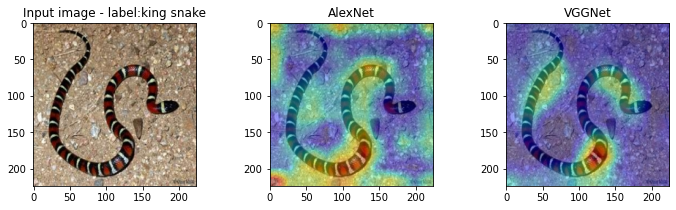

torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 256, 6, 6])
통과 후 gradient shape torch.Size([256, 6, 6])
weights shape torch.Size([256, 1, 1])
conv_features shape torch.Size([1, 256, 13, 13])
gcam shape torch.Size([13, 13])
torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 512, 7, 7])
통과 후 gradient shape torch.Size([512, 7, 7])
weights shape torch.Size([512, 1, 1])
conv_features shape torch.Size([1, 512, 14, 14])
gcam shape torch.Size([14, 14])


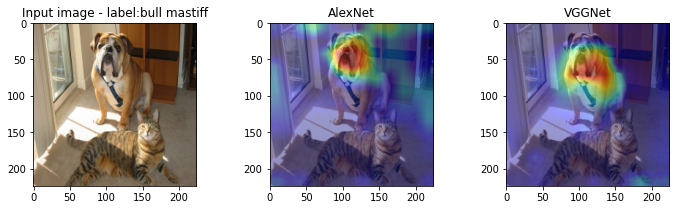

torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 256, 6, 6])
통과 후 gradient shape torch.Size([256, 6, 6])
weights shape torch.Size([256, 1, 1])
conv_features shape torch.Size([1, 256, 13, 13])
gcam shape torch.Size([13, 13])
torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 512, 7, 7])
통과 후 gradient shape torch.Size([512, 7, 7])
weights shape torch.Size([512, 1, 1])
conv_features shape torch.Size([1, 512, 14, 14])
gcam shape torch.Size([14, 14])


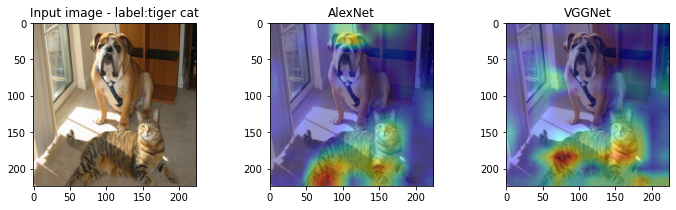

torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 256, 6, 6])
통과 후 gradient shape torch.Size([256, 6, 6])
weights shape torch.Size([256, 1, 1])
conv_features shape torch.Size([1, 256, 13, 13])
gcam shape torch.Size([13, 13])
torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 512, 7, 7])
통과 후 gradient shape torch.Size([512, 7, 7])
weights shape torch.Size([512, 1, 1])
conv_features shape torch.Size([1, 512, 14, 14])
gcam shape torch.Size([14, 14])


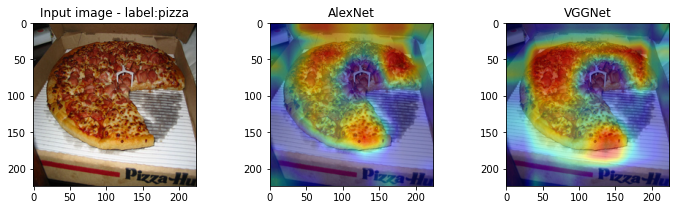

In [27]:
# Instantiation
gradcam_Alex = GradCAM(model_AlexNet)
gradcam_VGG = GradCAM(model_VGGnet)

for i in range(len(test_list)):
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.to(device)
    
    cam_img_AlexNet = gradcam_Alex.gen_CAM(img, one_hot_target)
    cam_img_VGGNet = gradcam_VGG.gen_CAM(img, one_hot_target)

    fig = plt.figure(figsize=(12, 3))
    fig.add_subplot(1,3,1).set_title('Input image - label:{}'.format(imagenet_class[target_class]))
    plt.imshow(reprocess_image(img))
    fig.add_subplot(1,3,2).set_title('AlexNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_AlexNet, alpha=0.4, cmap='jet')
    fig.add_subplot(1,3,3).set_title('VGGNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_VGGNet, alpha=0.4, cmap='jet')
    plt.show()

## Guided Grad-CAM: Grad-CAM with Guided Backpropagation
>- Grad-CAM visualization is class-discriminative (i.e. localize the target category) but not high-resolution (i.e. capture fine-grained detail) 
>- Pixel-space gradient visualizations such as Guided Backpropagation highlights fine-grained details in the image
>- Two methods are fused to combine these two aspects (Pointwise multiplication in the figure below)

<img src="https://docs.google.com/uc?export=view&id=1ByM4truwzT7-arXpc8jee-nHbM9QUg1X" alt="no_image" style="width: 900px;"/>

### Guided Backpropagation[6]
> - Before Guided Backprogation : two approaches for visualizing
>> 1.The deconvolutional network ('deconvnet') an approach to visualizing concepts learned by neurons of a CNN [7]
>> - Given a high-level feature map, the 'deconvnet' inverts the data flow of a CNN, going from neuron activations in the given layer down to an input image
>> - Then the reconstructed image shows the part of the input image that is most strongly activating neurons in the given layer 
>> - Reference for 'deconvnet' : [8] <br>
>>    
>> <img src="https://docs.google.com/uc?export=view&id=1aLCwRfv_4XrRBoqyFOhGiau-fg6QW-Zs" alt="no_image" style="width: 900px;"/>
>> 2.An alternative way of visualizing the part of an image that most activates a given neuron is to use a simple backward pass of the activtaion of that neuron after a forward pass ('backpropagation') 
>
>- These two methods differ mainly in the way they handle backpropagtion through the rectified linear nonlinearity(ReLU) as in the figure below
>- **Guided Backpropagation** combines these two methods: <br> 
> Rather than masking out values corresponding to negative entries of the top gradient('deconvnet') or bottom data('backpropagation), masking out the values for which at least one of these values is negative 

<img src="https://docs.google.com/uc?export=view&id=15Yp2ze2PRK5cUvh6-DE4cSY7BZRxnYYW" alt="no_image" style="width: 900px;"/>

### Guided Backpropagation Visualization

In [28]:
class GBackprop():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        # First layer of network where we register hook to
        self.first_layer = self.model.features[0]
        self.gradient = None 
        # hook functions to relus
        self.hook_relu()

    def hook_img_grad(self, grad):
        self.gradient = grad
        
    # register hook to module(ReLU)
    def hook_relu(self):
        # To pass only positive gradients at ReLU
        def relu_gradient(module, grad_input, grad_output):
            if isinstance(module, nn.ReLU):
                ############ print(grad_input[1].size()) # 
                ## print(grad_input[0].size()) # 
                return (torch.clamp(grad_input[0], min=0.0),)
        
        for module in self.model.features.modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(relu_gradient)
                #module.register_module_full_backward_hook(relu_gradient)
    
    def forward_model(self,x):
        x = self.model.features(x)
        x = x.view(x.size(0), -1)
        x = self.model.classifier(x)
        return x
    
    def gen_mask(self, img, one_hot_target):
        img.register_hook(self.hook_img_grad)
        
        output = self.forward_model(img)
        self.model.zero_grad()
        
        # for gradient computing with our specified class
        output.backward(gradient = one_hot_target)
        
        # our visualization mask (to array)
        self.gradient = self.gradient.detach().cpu().numpy()[0]
        
        # gradients mask 
        gradients_mask = self.gradient.transpose(1,2,0)
        gradients_mask = (gradients_mask - np.min(gradients_mask))/\
            (np.max(gradients_mask) - np.min(gradients_mask) + 1e-08)
        
        return self.gradient, gradients_mask 

#### 1.AlexNet


In [29]:
guided_backprop = GBackprop(model_AlexNet)

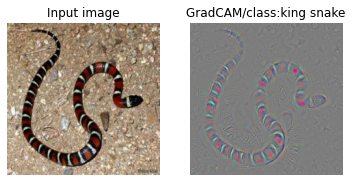

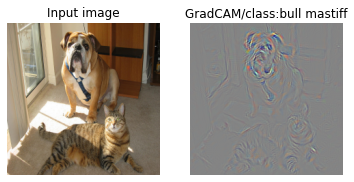

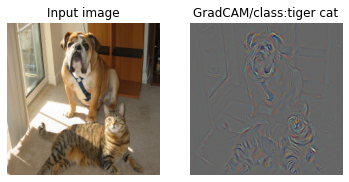

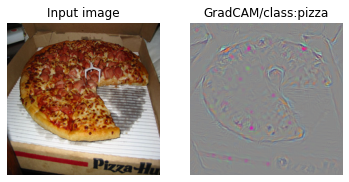

In [30]:
for i in range(len(test_list)):
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    fig = plt.figure()
    fig.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    fig.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(mask)
    plt.axis('off')

#### 2.VGGnet


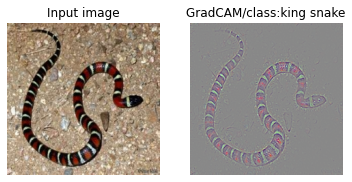

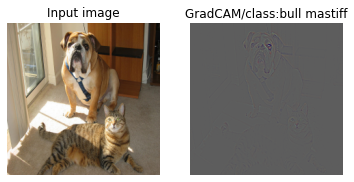

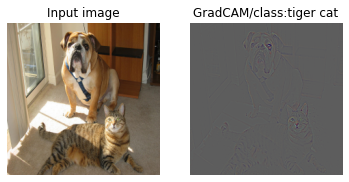

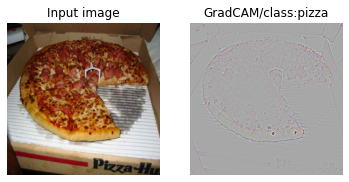

In [31]:
guided_backprop = GBackprop(model_VGGnet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    gradient_numpy,mask = guided_backprop.gen_mask(img, one_hot_target)
    
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(mask)
    plt.axis('off')

### Guided Grad-CAM visualization

#### 1.AlexNet

torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 256, 6, 6])
통과 후 gradient shape torch.Size([256, 6, 6])
weights shape torch.Size([256, 1, 1])
conv_features shape torch.Size([1, 256, 13, 13])
gcam shape torch.Size([13, 13])
torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 256, 6, 6])
통과 후 gradient shape torch.Size([256, 6, 6])
weights shape torch.Size([256, 1, 1])
conv_features shape torch.Size([1, 256, 13, 13])
gcam shape torch.Size([13, 13])
torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 256, 6, 6])
통과 후 gradient shape torch.Size([256, 6, 6])
weights shape torch.Size([256, 1, 1])
conv_features shape torch.Size([1, 256, 13, 13])
gcam shape torch.Size([13, 13])
torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 256, 6, 6])
통과 후 gradient shape torch.Size([256, 6, 6])
weights shape torch.Size([256, 1, 1])
conv_features shape torch.Size([1, 256, 13, 13])
gcam shape torch.Size([13, 13])


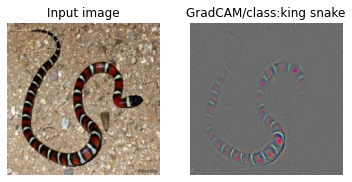

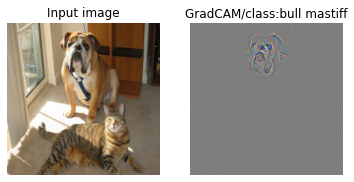

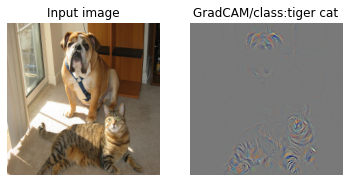

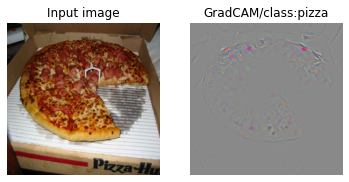

In [32]:
gradcam = GradCAM(model_AlexNet)
guided_backprop = GBackprop(model_AlexNet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    cam_img = gradcam.gen_CAM(img, one_hot_target)    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    guided_gradcam = np.multiply(cam_img, gradient_numpy).transpose(1,2,0)
    guided_gradcam = (guided_gradcam - np.min(guided_gradcam)) /\
            (np.max(guided_gradcam) - np.min(guided_gradcam) + 1e-08)
    
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(guided_gradcam)
    plt.axis('off')

#### 2. VGGnet

torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 512, 7, 7])
통과 후 gradient shape torch.Size([512, 7, 7])
weights shape torch.Size([512, 1, 1])
conv_features shape torch.Size([1, 512, 14, 14])
gcam shape torch.Size([14, 14])
torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 512, 7, 7])
통과 후 gradient shape torch.Size([512, 7, 7])
weights shape torch.Size([512, 1, 1])
conv_features shape torch.Size([1, 512, 14, 14])
gcam shape torch.Size([14, 14])
torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 512, 7, 7])
통과 후 gradient shape torch.Size([512, 7, 7])
weights shape torch.Size([512, 1, 1])
conv_features shape torch.Size([1, 512, 14, 14])
gcam shape torch.Size([14, 14])
torch.Size([1, 3, 224, 224])
gradient shape torch.Size([1, 512, 7, 7])
통과 후 gradient shape torch.Size([512, 7, 7])
weights shape torch.Size([512, 1, 1])
conv_features shape torch.Size([1, 512, 14, 14])
gcam shape torch.Size([14, 14])


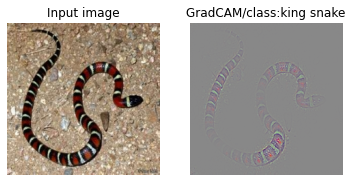

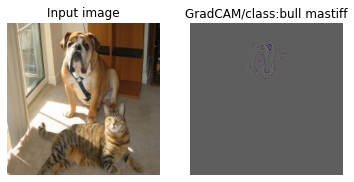

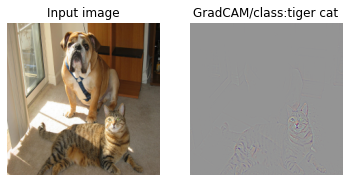

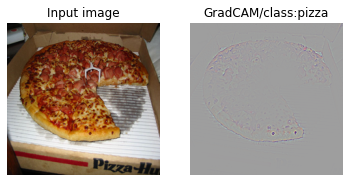

In [33]:
gradcam = GradCAM(model_VGGnet)
guided_backprop = GBackprop(model_VGGnet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)

    cam_img = gradcam.gen_CAM(img, one_hot_target)    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    guided_gradcam = np.multiply(cam_img, gradient_numpy).transpose(1,2,0)
    guided_gradcam = (guided_gradcam - np.min(guided_gradcam))/\
            (np.max(guided_gradcam) - np.min(guided_gradcam) + 1e-08)
  
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(guided_gradcam)
    plt.axis('off')

### *References*
[1] https://arxiv.org/pdf/1610.02391.pdf <br>
[2] https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf <br>
[3] https://arxiv.org/pdf/1409.1556.pdf <br>
[4] https://bob3rdnewbie.tistory.com/320 <br>
[5] https://pytorch.org/docs/stable/autograd.html#torch.Tensor.register_hook <br>
[6] https://arxiv.org/pdf/1412.6806.pdf <br>
[7] https://arxiv.org/pdf/1311.2901.pdf <br>
[8] https://medium.com/@jamesvanneman/paper-club-visualizing-and-understanding-convolutional-networks-629fef9ceb8b <br>

CAM 논문에서는 GAP를 사용한 CNN model의 성능을 시각적으로 분석가능한 기술을 제안했다. 그 결과 classification task로 학습시킨 모델이 localization에서도 이용할 수 있다는 것을 확인할 수 있었다.(CAM이 색칠되있는 부분을 localization이라고 볼때)


반면 grad-CAM의 경우에는 CAM의 한계인 GAP를 특정 조건에서만 사용가능하다는 한계를 극복한 gradient 방법을 개발하였다. 이로 인해서 CAM 처럼 model을 변형하지 않고 그 model의 자체 성능을 분석가능해졌다. 그리고 기존의 고해상도 시각화 기술을 결합
하여 Guided Grad-CAM을 만들었다. 이로 인해 인간 연구를 진행한 결과
기존 연구보다 더 확실하게 classification결과든지 localization결과 등 의미 있는 결과를 보임을 입증했다.




예상했던 점 : Grad-CAM과 Guided Backpropagation 을 결합한 Guided Grad-CAM의 경우에 훨씬 정확하게 model이 무엇을 보고 판단할 수 있는지 파악할 수 있다. Grad-CAM의 결과를 보더라도 사실 어떤 곳을 보고 분류했는지 알 수 있다. 하지만 Guided Backpropagation과 결합하면 보다 정밀하게 어떤 특징을 보고 model이 판단했는지 알 수 있다. Guided Backpropagation의 경우도 충분히 의미있는 결과를 내는 것처럼 보이지만 특히 GradCAM/call: tiger cat을 비교했을 때 Guided Backpropagation의 경우는 dog와 cat 모두 보인다. 하지만  Guided Grad-CAM의 경우에는 이 정도가 덜 심하며 대체로 cat에 집중되어 있는 것을 볼 수 있다. 이를  class-discriminative라고 한다. 

예상과 달랐던 점 및 개선할 점 : 
이 실험에서는 CIVA 10으로 pretrain된 모델을 그대로 grad-CAM으로 분석했다. 이미 학습이 완료된 모델임에도 불구하고 Guided Grad-CAM의 경우 사람이 생각하는 영역보다 훨씬 적은 부분으로 분류를 한 것을 볼 수 있고 VGGnet기반 Guided Grad-CAM의 경우에는 king snake를 보면 중간중간 옅어진 부분을 볼 수 있다. 이를 충분히 개선할 필요가 있을 것으로 보인다. 왜냐하면 XAI로 하고자 하는 것은 의료나 자율주행의 정확도를 높이기 위한 것이니 말이다. 

결론 : 결론적으로 XAI의 기본이 되는 CAM를 구현해보았다.

의문점 : Grad-CAM의 발전 모델이 Grad_CAM ++ 인데 어떤 점의 향상이 되었을지 궁금하다. 